In [4]:
import pandas as pd
import igraph as ig
from ease import EASE
import seaborn as sns
import numpy as np
import pickle

path = './files/'

In [96]:
# load gene set dictionaries - msigdb
def open_pickle(file):
    with open(path+file, 'rb') as pickle_file:
        return pickle.load(file=pickle_file)
    
msigdb_c6_dict = open_pickle('msigdb_c6_all_dict.pkl')
misgdb_c2_cgp_dict = open_pickle('msigdb_c2_cgp_dict.pkl')
misgdb_c3_tft_dict = open_pickle('msigdb_c3_tft_dict.pkl')


In [ ]:
kegg_pathways = pd.read_csv(filepath_or_buffer='./files/kegg_hsa_pathways', names=['pathway', 'kegg_id'], sep='\t') # 36381
uniprot_ids = pd.read_csv(filepath_or_buffer='./files/uniprot_ids', names=['kegg_id', 'uniprot_id'], sep='\t', skiprows=1) # 517 not matched!!!  8251 matched
uniprot_ids = uniprot_ids[~(uniprot_ids['kegg_id'] == uniprot_ids['uniprot_id'])]
uniprot_ids.shape
id_map = uniprot_ids.set_index('kegg_id')['uniprot_id'].to_dict()
len(id_map)
kegg_pathways = kegg_pathways.replace(to_replace=id_map, limit=0)
kegg_pathways.columns = ['pathway', 'uniprot_id']
pathways_dict = kegg_pathways.groupby('pathway')['uniprot_id'].apply(list).to_dict()
# kegg_pathways = 
# # !!!!! SHOULD I FILTER OUT NON UNIPROT ONE?? !!! - probably yes
# KEGG ids point towards multiple uniprot accessions - how to handle multiple accessions
# have to filter out non matched !!!!!!

# number of kegg entries mapped to more than 1 uniprot entry
uniprot_ids_counts = uniprot_ids['kegg_id'].value_counts()
multi_mapped = uniprot_ids_counts.where(uniprot_ids_counts > 1).dropna().shape # 23 entries assigned more than 1 uniprot entry
print(f"number of kegg entries mapped to multiple uniprot entries: {multi_mapped}")


# number of kegg pathwways
print(f"Number of kegg pathways: {len(kegg_pathways['pathway'].unique())}")

/tmp/ipykernel_1944/321458049.py:7: FutureWarning: The 'limit' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  kegg_pathways = kegg_pathways.replace(to_replace=id_map, limit=0)


In [81]:
# get network data from pickle  
regulome_network_edges = pd.read_csv(filepath_or_buffer='./files/human_regulome_pd.gz', compression='infer')
regulome_network_edges = regulome_network_edges.astype({'ProteinAid': 'str', 'ProteinBid':'str'})

regulome_network_graph = ig.Graph.DataFrame(regulome_network_edges, directed=True, use_vids = False)
regulome_network_graph_undirected = ig.Graph.DataFrame(regulome_network_edges, directed=False, use_vids = False)

In [190]:
# Investigate Leiden resolution
std_output = pd.DataFrame({
    'pathway_id': ['---'],
    'Overlap': [0],
    'Pvalue': [1],
    'FDR': [1],
    'FWER': [1] 
})
cov = 4000 # what should I set this to??

def cluster_leiden(graph, res, b=0.01, n_iter=3):
    return graph.community_leiden(objective_function='modularity',
                                weights='PPV',
                                resolution=res,
                                beta=b,
                                n_iterations=n_iter) # only few small clusters and 1 large one

def cluster_louvain(graph, res):
    return graph.community_multilevel(weights='PPV',
                                    return_levels=False,
                                    resolution=res)



cluster_enrichment_dict = dict() # output is a dictionary (resolution) of tuple with dictionary (per cluster) containing tuple with a pandas df (containing enrichment fr each pathway)
for res in np.arange(1, 10, 1):
    print(f"Reslution: {res}")
    clusters = cluster_leiden(regulome_network_graph_undirected, res=res, b=0.05)

    enrichment_dict = dict()
    for (cluster_n, cluster) in enumerate(clusters.subgraphs()):
        query = cluster.vs['name']
        if (len(query) > 500) or (len(query) < 10):
            continue
        enrichment = EASE(query_set=query, genesets=misgdb_c2_cgp_dict, PT=cov)
        enrichment_dict[cluster_n] = (enrichment, len(query), query) # maybe save this as a namedtuple with enrihcment and subgraph
    cluster_enrichment_dict[res] = (enrichment_dict, len(enrichment_dict))

Reslution: 1
Reslution: 2
Reslution: 3
Reslution: 4
Reslution: 5
Reslution: 6
Reslution: 7
Reslution: 8
Reslution: 9


In [194]:
# save to pickle
with open(path+'clustering_results/misgdb_c2_leiden_1_10_1_b005.pkl', 'wb') as file:
    pickle.dump(cluster_enrichment_dict, file=file)

In [195]:
distributions_df = pd.DataFrame()
for (res, cluster_enrichments) in cluster_enrichment_dict.items():
    n_clusters = cluster_enrichments[1]
    cluster_sizes = [cluster[1] for cluster in cluster_enrichments[0].values()]
    distributions_df = pd.concat([distributions_df, pd.DataFrame({'size': cluster_sizes, 'resolution':[res]*n_clusters})])

In [196]:
distributions_df

,size,resolution
0,166,1
0,292,2
1,287,2
2,210,2
3,16,2
...,...,...
560,38,9
561,27,9
562,32,9
563,20,9


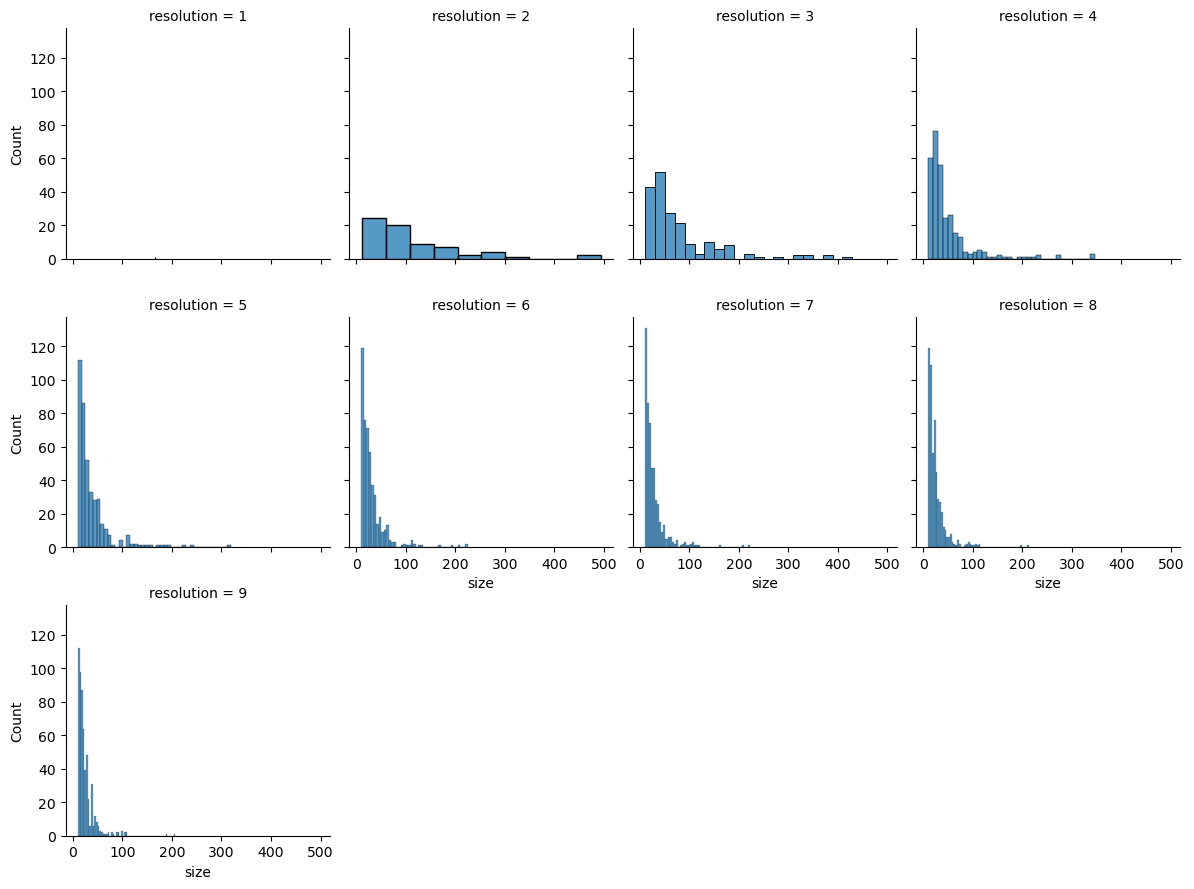

In [204]:
fig = sns.FacetGrid(distributions_df, col='resolution', col_wrap=4)
fig.map(sns.histplot, 'size')

2


(0.0, 500.0)

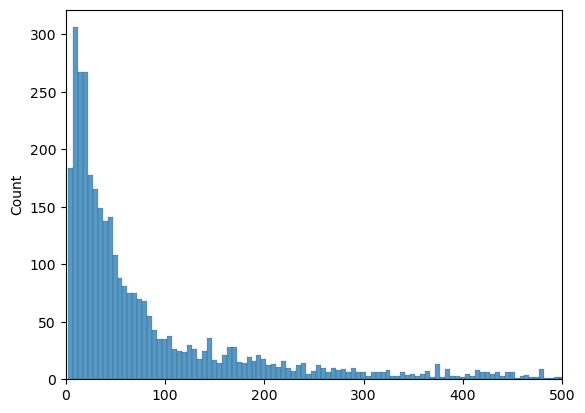

In [200]:
set_sizes = [len(gene_set) for gene_set in misgdb_c2_cgp_dict.values()] 
print(min(set_sizes))
sns.histplot(set_sizes, binwidth=5).set_xlim([0,500])

In [116]:
CCS_dict = dict()
threshold = 0.005

for (res, cluster_enrichments) in cluster_enrichment_dict.items():
    enriched_list = list()
    enrichment_dict = cluster_enrichments[0]
    n_clusters = cluster_enrichments[1] # number of appropriately sized clusters, filtered before EASE
    for _, enrichment in enrichment_dict.items():
        enrichment = enrichment[0]
        enriched = enrichment[enrichment.FDR < threshold]
        if len(enriched) != 0:
            enriched_list.append(enriched)

    if len(enriched_list) == 0:
        CCS_dict[res] = (pd.DataFrame({'pathway_id': [],
                                                'Overlap': [],
                                                'Pvalue': [],
                                                'FDR': [],
                                                'FWER': []}), 0)
        continue
    
    enriched_df = pd.concat(enriched_list)
    avg_nr_path = len(enriched_list) / n_clusters
    avg_cluster_per_path = len(pd.unique(enriched_df['pathway_id']))/n_clusters
    CCS = avg_nr_path/avg_cluster_per_path

    CCS_dict[res] = (enriched_df, CCS)

<Axes: >

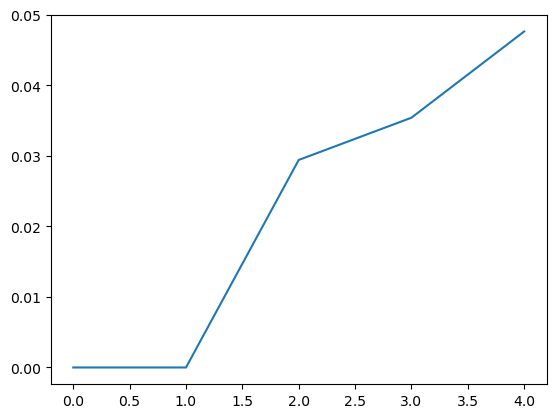

In [117]:
CCS_list = [CCS[1] for CCS in CCS_dict.values()]
resolutions = CCS_dict.keys()

sns.lineplot(x=resolutions, y=CCS_list)

(0.0, 10.0)

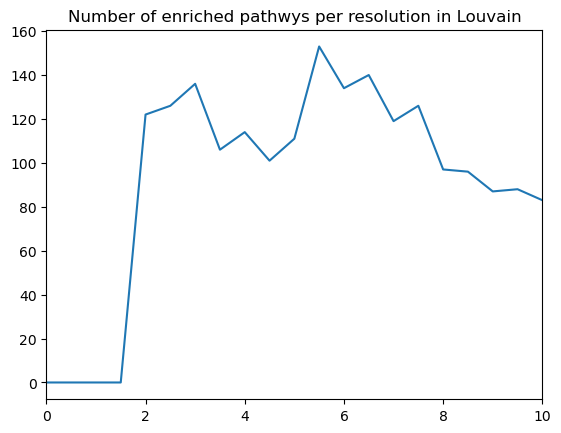

In [108]:
num_pathways = list()
for res, hits in CCS_dict.items():
    num_pathways.append(len(hits[0].pathway_id.unique()))
num_pathways
 
plot = sns.lineplot(x=resolutions, y=num_pathways)
plot.set_title("Number of enriched pathwys per resolution in Louvain")
plot.set_xlim([0,10])


<Axes: >

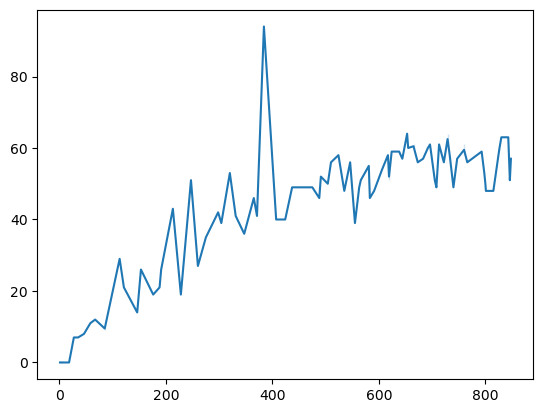

In [210]:
n_clusters = [n[1] for n in leiden_cluster_enrichment_dict.values()]

sns.lineplot(x=n_clusters, y=num_pathways)

In [ ]:
infomap_clusters = regulome_network_graph.community_infomap(edge_weights='5:PPV', trials=10) # generaetd some small clusters and 1 large one

In [ ]:


leiden_clusters = regulome_network_graph_undirected.community_leiden(objective_function='modularity',
                                                          weights='5:PPV',
                                                          resolution=12.0,
                                                          beta=0.01,
                                                          n_iterations=3) # only few small clusters and 1 large one

In [123]:
# non-overlapping   

louvain_clusters = regulome_network_graph_undirected.community_multilevel(weights='PPV',
                                                                          return_levels=False,
                                                                          resolution=5)